In [3]:
import polars as pl
import pyarrow.parquet as pq
import sys

filepath = "../Data/processed/sirene_infos_FINAL_DuelML.parquet" 

print("--- Début de la lecture 'bypass' ---")

try:
    print(f"Lecture du fichier via PyArrow : {filepath}")
    table_arrow = pq.read_table(
        filepath,
    )
    
    print("Conversion de la table PyArrow en DataFrame Polars...")
    df_bilan = pl.from_arrow(table_arrow)
    
    print("--- SUCCÈS ! ---\n")
    print("Le DataFrame est maintenant dans Polars, prêt pour la transformation.")
    print(df_bilan.head())

except Exception as e:
    print(f"\n--- ERREUR ---", file=sys.stderr)
    print(f"Impossible de lire le fichier, même avec PyArrow : {e}", file=sys.stderr)

--- Début de la lecture 'bypass' ---
Lecture du fichier via PyArrow : ../Data/processed/sirene_infos_FINAL_DuelML.parquet
Conversion de la table PyArrow en DataFrame Polars...
--- SUCCÈS ! ---

Le DataFrame est maintenant dans Polars, prêt pour la transformation.
shape: (5, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ siren     ┆ date_clot ┆ CJCK_Tota ┆ HN_Résult ┆ … ┆ ratio_tre ┆ anciennet ┆ cible_Res ┆ cible_HN │
│ ---       ┆ ure_exerc ┆ lActifBru ┆ atNet     ┆   ┆ sorerie   ┆ e_entrepr ┆ ultatNet_ ┆ _Résulta │
│ str       ┆ ice       ┆ t         ┆ ---       ┆   ┆ ---       ┆ ise       ┆ T_plus_1  ┆ tNet_T_p │
│           ┆ ---       ┆ ---       ┆ i32       ┆   ┆ f64       ┆ ---       ┆ ---       ┆ lus_1    │
│           ┆ date      ┆ i32       ┆           ┆   ┆           ┆ i32       ┆ i32       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ i32      │
╞═══════════╪═

In [8]:
df_bilan.schema

Schema([('siren', String),
        ('date_cloture_exercice', Date),
        ('CJCK_TotalActifBrut', Int32),
        ('HN_RésultatNet', Int32),
        ('DA_TresorerieActive', Int32),
        ('DL_DettesCourtTerme', Int32),
        ('AnneeClotureExercice', Int32),
        ('ratio_endettement', Float64),
        ('ratio_tresorerie', Float64),
        ('anciennete_entreprise', Int32),
        ('cible_ResultatNet_T_plus_1', Int32),
        ('cible_HN_RésultatNet_T_plus_1', Int32)])

In [9]:
# renome la colonne cible_HN_RésultatNet_T_plus_1 en variation_RésultatNet

df_bilan = df_bilan.rename({
    "cible_HN_RésultatNet_T_plus_1": "variation_RésultatNet"
})

In [5]:
import polars as pl
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# 1. DATA PREP
# =========================
df = df_bilan.to_pandas()

# enlève les trois premières colonnes (ID, année, etc.)
df = df.iloc[:, 3:]

X = df.drop('cible_ResultatNet_T_plus_1', axis=1)
y = df['cible_ResultatNet_T_plus_1']

# Train / test split (test kept untouched for final evaluation)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# =========================
# 2. BASELINE MODEL
# =========================
print(f"\n[BASELINE] Entraînement sur {len(X_train)} entreprises...")

baseline_model = xgb.XGBRegressor(
    objective='reg:absoluteerror',  # optimise MAE
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_train, y_train)
baseline_pred = baseline_model.predict(X_test)

baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

print("\n--- PERFORMANCE BASELINE ---")
print(f"MAE : {baseline_mae:,.2f} €")
print(f"R²  : {baseline_r2:.4f}")

# =========================
# 3. HYPERPARAMETER SEARCH (RandomizedSearchCV)
# =========================
print("\n[SEARCH] Optimisation des hyperparamètres avec RandomizedSearchCV...")

param_dist = {
    "n_estimators": [300, 600, 900, 1200, 1500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "max_depth": [3, 5, 7, 9],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5, 10],
    "gamma": [0, 0.1, 0.3, 1.0],
    "reg_alpha": [0, 0.1, 1.0],
    "reg_lambda": [0.5, 1.0, 2.0],
}

search_model = xgb.XGBRegressor(
    objective='reg:absoluteerror',
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=search_model,
    param_distributions=param_dist,
    n_iter=10,                    # nombre d'essais (augmentable si tu veux)
    scoring='neg_mean_absolute_error',
    cv=5,                         # 5-fold CV (exigence du cours)
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("\nMeilleurs hyperparamètres trouvés :")
print(random_search.best_params_)
print(f"MAE CV (val) ≈ {-random_search.best_score_:,.2f} €")

# =========================
# 4. FINAL MODEL AVEC EARLY STOPPING (CORRIGÉ)
# =========================
print("\n[FINAL] Ré-entraînement du meilleur modèle avec early stopping...")

# 1. Importer et définir le callback
from xgboost.callback import EarlyStopping 

best_params = random_search.best_params_

# On refait un split interne pour early stopping (train / valid)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

final_model = xgb.XGBRegressor(
    **best_params,
    objective='reg:absoluteerror',
    random_state=42,
    n_jobs=-1
)

# Configure le callback pour l'arrêt anticipé sur la MAE de l'ensemble de validation
early_stopping = EarlyStopping(
    rounds=50, 
    metric_name='mae', 
    data_name='validation' # Le nom de l'ensemble de données dans eval_set est "validation" par défaut.
)

final_model.fit(
    X_tr, y_tr,
    eval_set=[(X_val, y_val)],
    # Utilise le callback pour l'arrêt anticipé
    callbacks=[early_stopping],
    verbose=50
)
# ... le reste du code est correct

# ==========================================
# 5. RÉSULTATS SUR LE TEST SET
# ==========================================
predictions = final_model.predict(X_test)

mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("\n--- PERFORMANCE MODÈLE OPTIMISÉ ---")
print(f"MAE : {mae:,.2f} € (baseline : {baseline_mae:,.2f} €)")
print(f"R²  : {r2:.4f} (baseline : {baseline_r2:.4f})")

# =========================
# 6. FEATURE IMPORTANCE
# =========================
plt.figure(figsize=(12, 8))
xgb.plot_importance(final_model, max_num_features=20, height=0.5,
                    title="Variables les plus influentes sur le Résultat Net N+1")
plt.tight_layout()
plt.savefig("feature_importance.png")

# =========================
# 7. PLOT PRÉDICTION vs RÉALITÉ
# =========================
plt.figure(figsize=(10, 10))
plt.scatter(y_test, predictions, alpha=0.4, s=10)
p1 = max(max(predictions), max(y_test))
p0 = min(min(predictions), min(y_test))
plt.plot([p0, p1], [p0, p1], 'r--')
plt.xlabel('Vrai Résultat Net N+1')
plt.ylabel('Résultat Prédit N+1')
plt.title('Précision du Modèle XGBoost (optimisé)')
plt.xscale('symlog')
plt.yscale('symlog')
plt.tight_layout()
plt.savefig("prediction_vs_realite.png")

print("\nGraphiques générés : 'feature_importance.png' et 'prediction_vs_realite.png'")

(195822, 8) (48956, 8) (195822,) (48956,)

[BASELINE] Entraînement sur 195822 entreprises...

--- PERFORMANCE BASELINE ---
MAE : 176,894.16 €
R²  : 0.5943

[SEARCH] Optimisation des hyperparamètres avec RandomizedSearchCV...
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Meilleurs hyperparamètres trouvés :
{'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'n_estimators': 900, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.02, 'gamma': 0.3, 'colsample_bytree': 0.8}
MAE CV (val) ≈ 177,365.00 €

[FINAL] Ré-entraînement du meilleur modèle avec early stopping...


TypeError: XGBModel.fit() got an unexpected keyword argument 'callbacks'

Shapes (Train: (193224, 8), Test: (48306, 8))

[BASELINE] Entraînement sur 193224 entreprises...

--- PERFORMANCE BASELINE ---
MAE : 173,310.12 €
R²  : 0.6068

[SEARCH] Optimisation des hyperparamètres avec RandomizedSearchCV (CV=5)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=12, min_child_weight=5, n_estimators=500, reg_alpha=1.0, reg_lambda=0.5, subsample=0.9; total time=  24.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=12, min_child_weight=5, n_estimators=500, reg_alpha=1.0, reg_lambda=0.5, subsample=0.9; total time=  24.2s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=12, min_child_weight=5, n_estimators=500, reg_alpha=1.0, reg_lambda=0.5, subsample=0.9; total time=  24.3s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=12, min_child_weight=5, n_estimators=500, reg_alpha=1.0, reg_lambda=0.5, subsample=0.9; total time=  

/Users/ugo/Documents/Cours/Master/Cours/M1/Supervised Learning/Final Project/.venv/lib/python3.14/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.8, gamma=1.0, learning_rate=0.005, max_depth=12, min_child_weight=1, n_estimators=500, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=  26.7s
[CV] END colsample_bytree=0.8, gamma=1.0, learning_rate=0.005, max_depth=12, min_child_weight=1, n_estimators=500, reg_alpha=0.1, reg_lambda=0.5, subsample=0.9; total time=  26.7s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.005, max_depth=10, min_child_weight=1, n_estimators=1500, reg_alpha=2.0, reg_lambda=1.0, subsample=0.8; total time=  53.7s
[CV] END colsample_bytree=0.9, gamma=0.1, learning_rate=0.005, max_depth=10, min_child_weight=1, n_estimators=1500, reg_alpha=2.0, reg_lambda=1.0, subsample=0.8; total time=  55.1s
[CV] END colsample_bytree=0.9, gamma=0.5, learning_rate=0.005, max_depth=10, min_child_weight=10, n_estimators=2000, reg_alpha=1.0, reg_lambda=5.0, subsample=0.9; total time= 1.2min
[CV] END colsample_bytree=0.9, gamma=0.5, learning_rate=0.005, max_depth=10, min_child_weight=10

/Users/ugo/Documents/Cours/Master/Cours/M1/Supervised Learning/Final Project/.venv/lib/python3.14/site-packages/xgboost/callback.py:386: UserWarning: [00:40:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[50]	validation-mae:272764.60320
[100]	validation-mae:246646.75406
[150]	validation-mae:226993.70359
[200]	validation-mae:212018.67549
[250]	validation-mae:202192.54227
[300]	validation-mae:195190.65679
[350]	validation-mae:189728.71645
[400]	validation-mae:185679.47690
[450]	validation-mae:183071.77991
[500]	validation-mae:181015.81116
[550]	validation-mae:179498.10844
[600]	validation-mae:178325.43363
[650]	validation-mae:177596.13080
[700]	validation-mae:176996.12818
[750]	validation-mae:176581.15614
[800]	validation-mae:176234.23812
[850]	validation-mae:175924.16565
[900]	validation-mae:175700.81356
[950]	validation-mae:175511.65492
[1000]	validation-mae:175353.65249
[1050]	validation-mae:175209.99790
[1100]	validation-mae:175087.09094
[1150]	validation-mae:174978.64752
[1200]	validation-mae:174875.61971
[1250]	validation-mae:174799.85312
[1300]	validation-mae:174721.17685
[1350]	validation-mae:174668.26142
[1400]	validation-mae:174613.45875
[1450]	validation-mae:174557.45641
[1500

/var/folders/sp/97__4mlj3nbc2fssvlgn3_nh0000gn/T/ipykernel_27953/3137843541.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Graphiques générés : 'feature_importance.png' et 'prediction_vs_realite.png'


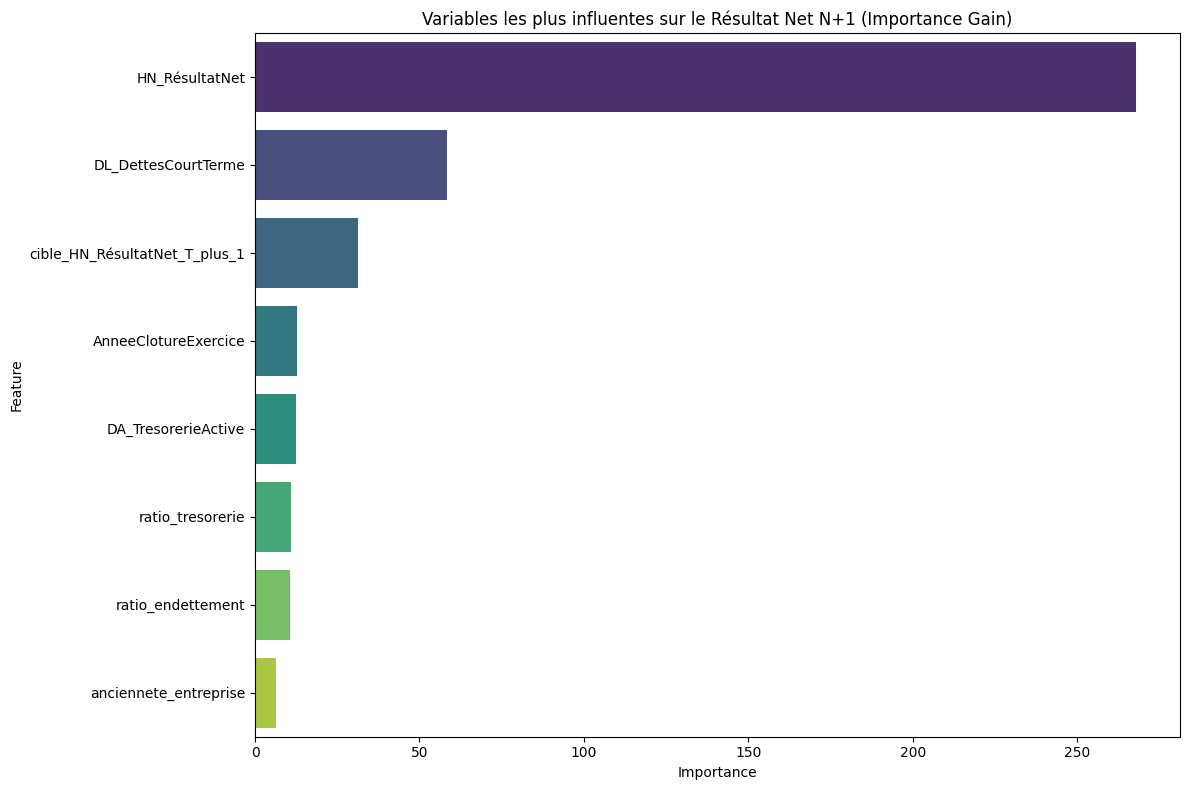

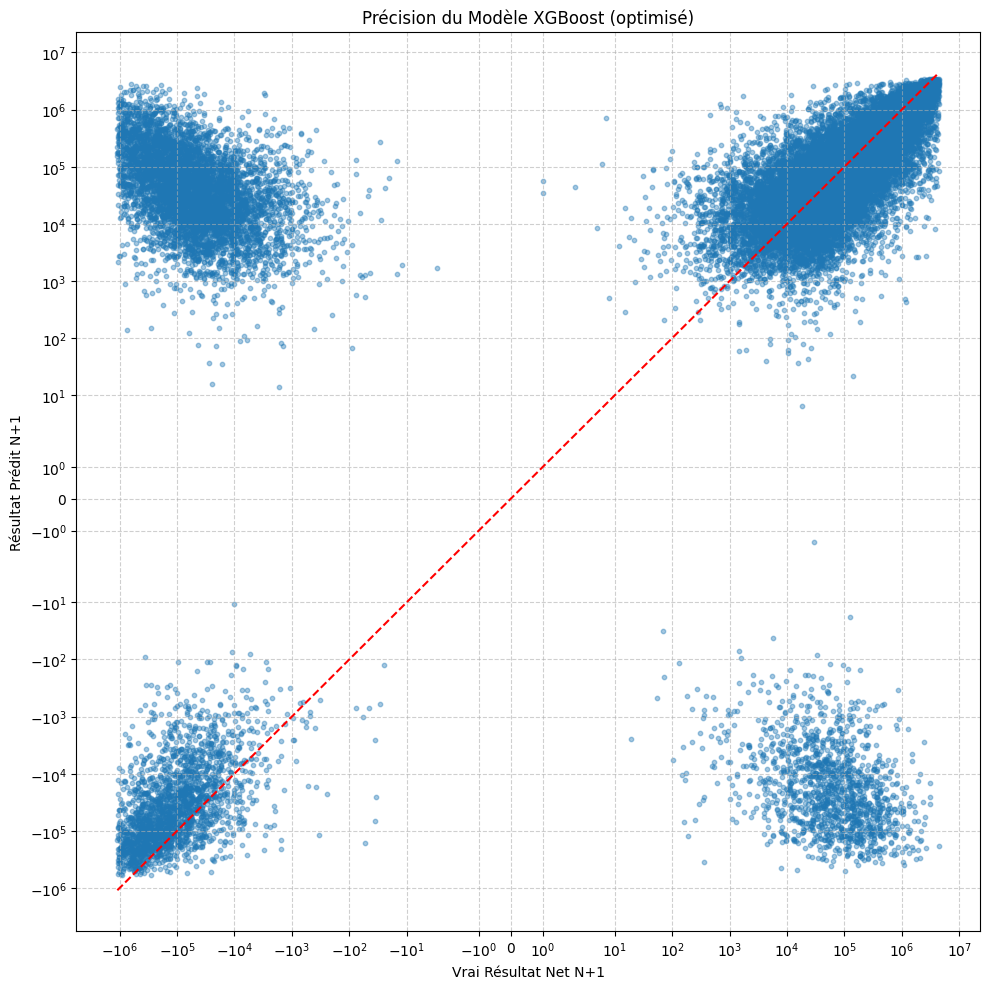

In [7]:
import polars as pl
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from xgboost.callback import EarlyStopping # Importation du callback
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Importation explicite de Pandas

# =========================
# 0. PRÉPARATION INITIALE & HYGIÈNE
# =========================
# Supposons que df_bilan est votre DataFrame Polars chargé au début du notebook.
# Si df_bilan n'est pas défini, cette ligne doit être remplacée par votre chargement de données.
# Exemple fictif : df_bilan = pl.read_csv("votre_fichier_bilan.csv")

# Conversion en Pandas pour la compatibilité scikit-learn/XGBoost
# Assurez-vous que 'df_bilan' est bien disponible dans votre environnement.
try:
    df = df_bilan.to_pandas()
except NameError:
    print("Erreur: df_bilan n'est pas défini. Veuillez charger vos données Polars.")
    # Fallback pour le test (à enlever en production)
    # df = pd.DataFrame(np.random.rand(100, 10))
    # df.columns = [f'feature_{i}' for i in range(7)] + ['col_a', 'col_b', 'cible_ResultatNet_T_plus_1']


# Nettoyage et division
# On suppose les 3 premières colonnes non-prédictives.
df = df.iloc[:, 3:]

# Gestion des valeurs manquantes/infinies si non fait auparavant
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna() # Stratégie simple : suppression des lignes (à affiner si nécessaire)

X = df.drop('cible_ResultatNet_T_plus_1', axis=1)
y = df['cible_ResultatNet_T_plus_1']

# Train / test split (Le TEST set reste Intouché pour l'évaluation finale [cite: 25])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Shapes (Train: {X_train.shape}, Test: {X_test.shape})")

# =========================
# 1. BASELINE MODEL
# =========================
print(f"\n[BASELINE] Entraînement sur {len(X_train)} entreprises...")

baseline_model = xgb.XGBRegressor(
    objective='reg:absoluteerror',  # Optimise la MAE
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_train, y_train)
baseline_pred = baseline_model.predict(X_test)

baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

print("\n--- PERFORMANCE BASELINE ---")
print(f"MAE : {baseline_mae:,.2f} €")
print(f"R²  : {baseline_r2:.4f}")

# =========================
# 2. HYPERPARAMETER SEARCH (RandomizedSearchCV)
# =========================
print("\n[SEARCH] Optimisation des hyperparamètres avec RandomizedSearchCV (CV=5)...")

# Utiliser make_scorer pour s'assurer que RandomizedSearchCV optimise bien la MAE (négative)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

param_dist = {
    # Espaces de recherche plus étendus pour la performance :
    "n_estimators": [500, 1000, 1500, 2000],
    "learning_rate": [0.005, 0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7, 10, 12],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "min_child_weight": [1, 5, 10],
    "gamma": [0, 0.1, 0.5, 1.0],
    # Régularisation plus aggressive peut aider :
    "reg_alpha": [0, 0.1, 0.5, 1.0, 2.0],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0],
}

search_model = xgb.XGBRegressor(
    objective='reg:absoluteerror', # Métrique interne pour l'entraînement
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=search_model,
    param_distributions=param_dist,
    n_iter=20, # Augmentation du nombre d'itérations pour une meilleure chance de trouver un optimum
    scoring=mae_scorer, # Optimisation directe sur la MAE
    cv=5,               # 5-fold CV (exigence du cours )
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("\nMeilleurs hyperparamètres trouvés :")
best_params = random_search.best_params_
print(best_params)
print(f"MAE CV (val) ≈ {-random_search.best_score_:,.2f} €")

# =========================
# 3. FINAL MODEL AVEC EARLY STOPPING (API NATIVE : FIXE L'ERREUR DE CALLBACKS)
# =========================
print("\n[FINAL] Ré-entraînement du meilleur modèle avec early stopping (API Native)...")

# 1. Split interne pour la validation de l'Early Stopping
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# 2. Création des DMatrix
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test) # DMatrix pour l'ensemble de test

# 3. Définition des paramètres pour l'API Native
params = {
    **best_params,
    'objective': 'reg:absoluteerror', 
    'eval_metric': 'mae', # Métrique utilisée pour l'arrêt anticipé
    'seed': 42
}

# 4. Configure le callback pour l'arrêt anticipé
early_stopping = EarlyStopping(
    rounds=50, 
    metric_name='mae', 
    data_name='validation'
)

# 5. Entraînement avec xgb.train()
final_model = xgb.train(
    params,
    dtrain,
    num_boost_round=best_params.get('n_estimators', 2000), # Utilise n_estimators max de la recherche
    evals=[(dval, "validation")],
    callbacks=[early_stopping], # Argument 'callbacks' fonctionnel dans xgb.train
    verbose_eval=50
)

# ==========================================
# 4. RÉSULTATS SUR LE TEST SET
# ==========================================
predictions = final_model.predict(dtest) # Utilisation de dtest pour la prédiction

mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("\n--- PERFORMANCE MODÈLE OPTIMISÉ (TEST SET) ---")
print(f"MAE : {mae:,.2f} € (baseline : {baseline_mae:,.2f} €)")
print(f"R²  : {r2:.4f} (baseline : {baseline_r2:.4f})")

# =========================
# 5. FEATURE IMPORTANCE (Utilise la méthode du modèle natif)
# =========================
# L'objet 'final_model' est maintenant une instance de 'Booster' de l'API native
importance = final_model.get_score(importance_type='gain')
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df.head(20), 
    palette="viridis"
)
plt.title("Variables les plus influentes sur le Résultat Net N+1 (Importance Gain)")
plt.tight_layout()
plt.savefig("feature_importance.png")

# =========================
# 6. PLOT PRÉDICTION vs RÉALITÉ
# =========================
plt.figure(figsize=(10, 10))
plt.scatter(y_test, predictions, alpha=0.4, s=10)
p1 = max(max(predictions), max(y_test))
p0 = min(min(predictions), min(y_test))
plt.plot([p0, p1], [p0, p1], 'r--')
plt.xlabel('Vrai Résultat Net N+1')
plt.ylabel('Résultat Prédit N+1')
plt.title('Précision du Modèle XGBoost (optimisé)')
# La mise à l'échelle symlog est essentielle pour visualiser les données financières
# ayant de grandes variations positives et négatives.
plt.xscale('symlog')
plt.yscale('symlog')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("prediction_vs_realite.png")

print("\nGraphiques générés : 'feature_importance.png' et 'prediction_vs_realite.png'")

Shapes (Train: (193224, 8), Test: (48306, 8))

[BASELINE] Entraînement sur 193224 entreprises...

--- PERFORMANCE BASELINE ---
MAE : 173,310.12 €
R²  : 0.6068

[SEARCH] Optimisation des hyperparamètres avec RandomizedSearchCV (CV=5)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=12, min_child_weight=5, n_estimators=500, reg_alpha=1.0, reg_lambda=0.5, subsample=0.9; total time=  26.8s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=12, min_child_weight=5, n_estimators=500, reg_alpha=1.0, reg_lambda=0.5, subsample=0.9; total time=  26.9s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=12, min_child_weight=5, n_estimators=500, reg_alpha=1.0, reg_lambda=0.5, subsample=0.9; total time=  27.1s
[CV] END colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_depth=12, min_child_weight=5, n_estimators=500, reg_alpha=1.0, reg_lambda=0.5, subsample=0.9; total time=  

/Users/ugo/Documents/Cours/Master/Cours/M1/Supervised Learning/Final Project/.venv/lib/python3.14/site-packages/xgboost/callback.py:386: UserWarning: [00:53:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[50]	validation-mae:272764.60320
[100]	validation-mae:246646.75406
[150]	validation-mae:226993.70359
[200]	validation-mae:212018.67549
[250]	validation-mae:202192.54227
[300]	validation-mae:195190.65679
[350]	validation-mae:189728.71645
[400]	validation-mae:185679.47690
[450]	validation-mae:183071.77991
[500]	validation-mae:181015.81116
[550]	validation-mae:179498.10844
[600]	validation-mae:178325.43363
[650]	validation-mae:177596.13080
[700]	validation-mae:176996.12818
[750]	validation-mae:176581.15614
[800]	validation-mae:176234.23812
[850]	validation-mae:175924.16565
[900]	validation-mae:175700.81356
[950]	validation-mae:175511.65492
[1000]	validation-mae:175353.65249
[1050]	validation-mae:175209.99790
[1100]	validation-mae:175087.09094
[1150]	validation-mae:174978.64752
[1200]	validation-mae:174875.61971
[1250]	validation-mae:174799.85312
[1300]	validation-mae:174721.17685
[1350]	validation-mae:174668.26142
[1400]	validation-mae:174613.45875
[1450]	validation-mae:174557.45641
[1500

/var/folders/sp/97__4mlj3nbc2fssvlgn3_nh0000gn/T/ipykernel_27953/3137843541.py:176: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Graphiques générés : 'feature_importance.png' et 'prediction_vs_realite.png'


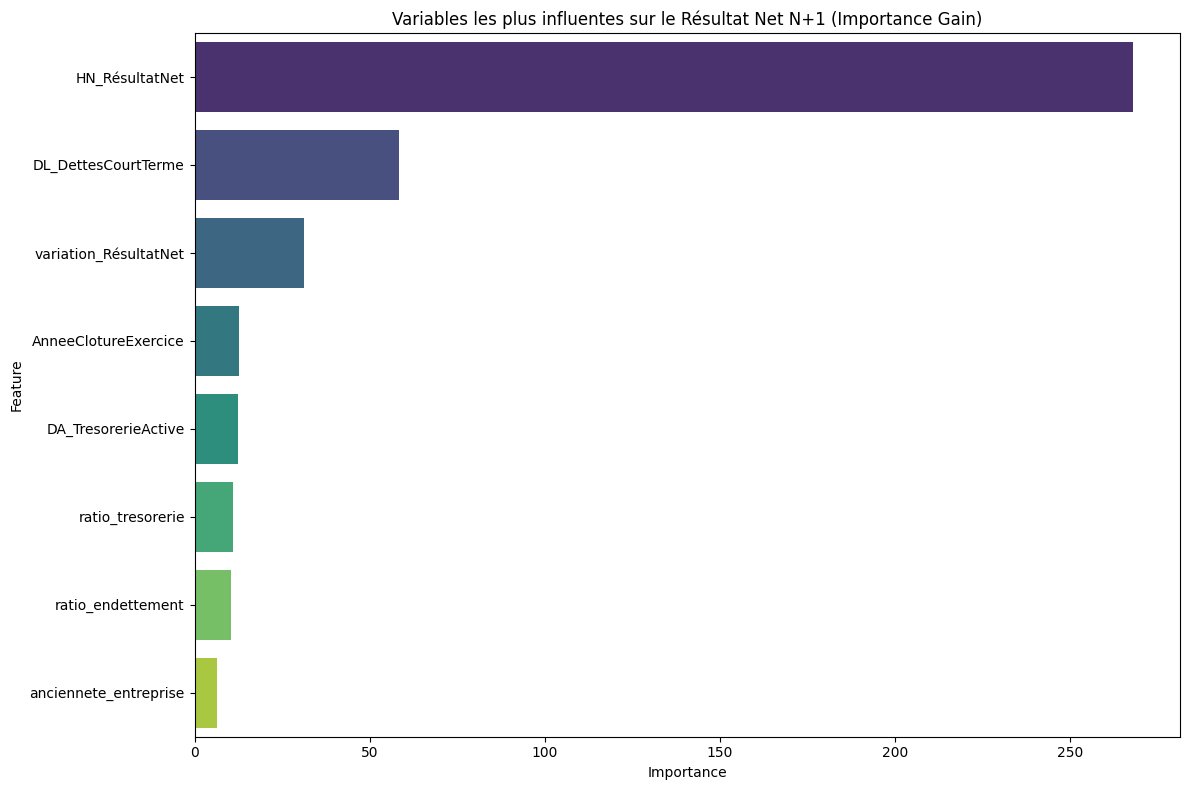

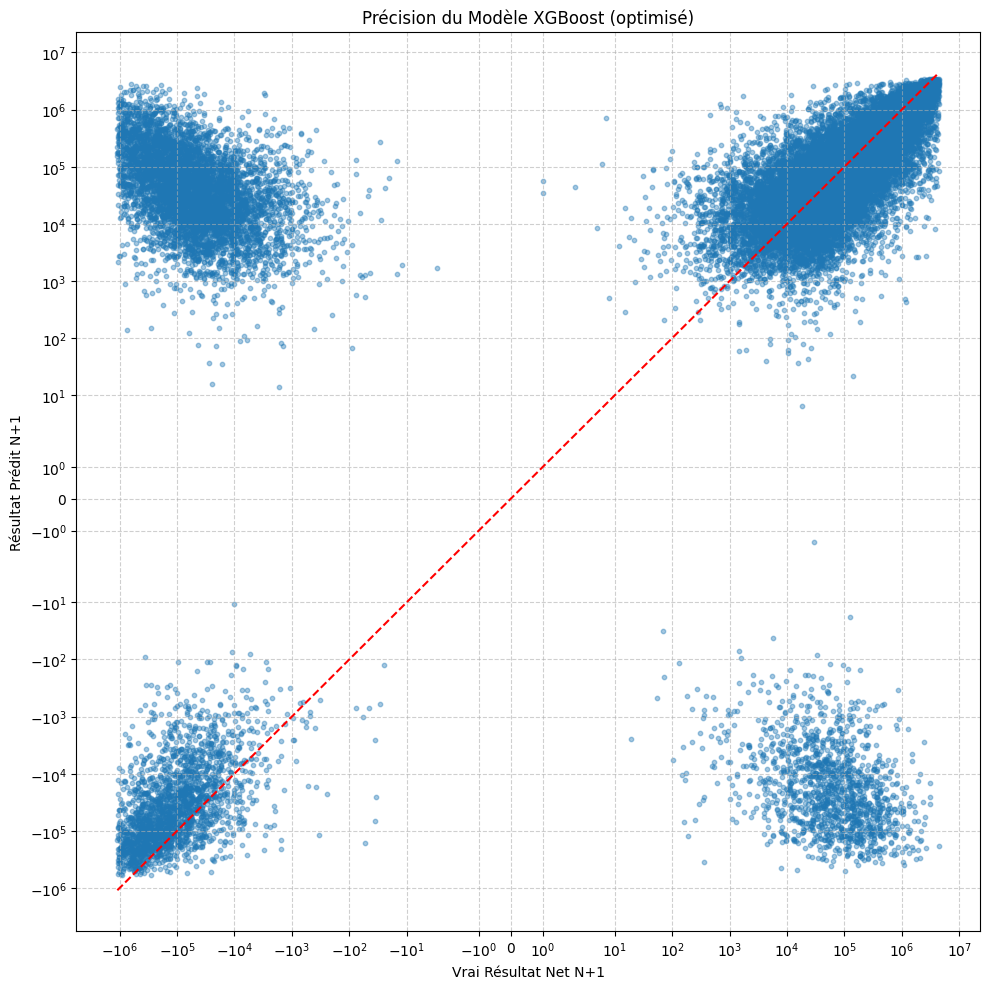

In [10]:
import polars as pl
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from xgboost.callback import EarlyStopping # Importation du callback
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Importation explicite de Pandas

# =========================
# 0. PRÉPARATION INITIALE & HYGIÈNE
# =========================
# Supposons que df_bilan est votre DataFrame Polars chargé au début du notebook.
# Si df_bilan n'est pas défini, cette ligne doit être remplacée par votre chargement de données.
# Exemple fictif : df_bilan = pl.read_csv("votre_fichier_bilan.csv")

# Conversion en Pandas pour la compatibilité scikit-learn/XGBoost
# Assurez-vous que 'df_bilan' est bien disponible dans votre environnement.
try:
    df = df_bilan.to_pandas()
except NameError:
    print("Erreur: df_bilan n'est pas défini. Veuillez charger vos données Polars.")
    # Fallback pour le test (à enlever en production)
    # df = pd.DataFrame(np.random.rand(100, 10))
    # df.columns = [f'feature_{i}' for i in range(7)] + ['col_a', 'col_b', 'cible_ResultatNet_T_plus_1']


# Nettoyage et division
# On suppose les 3 premières colonnes non-prédictives.
df = df.iloc[:, 3:]

# Gestion des valeurs manquantes/infinies si non fait auparavant
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna() # Stratégie simple : suppression des lignes (à affiner si nécessaire)

X = df.drop('cible_ResultatNet_T_plus_1', axis=1)
y = df['cible_ResultatNet_T_plus_1']

# Train / test split (Le TEST set reste Intouché pour l'évaluation finale [cite: 25])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Shapes (Train: {X_train.shape}, Test: {X_test.shape})")

# =========================
# 1. BASELINE MODEL
# =========================
print(f"\n[BASELINE] Entraînement sur {len(X_train)} entreprises...")

baseline_model = xgb.XGBRegressor(
    objective='reg:absoluteerror',  # Optimise la MAE
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_train, y_train)
baseline_pred = baseline_model.predict(X_test)

baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

print("\n--- PERFORMANCE BASELINE ---")
print(f"MAE : {baseline_mae:,.2f} €")
print(f"R²  : {baseline_r2:.4f}")

# =========================
# 2. HYPERPARAMETER SEARCH (RandomizedSearchCV)
# =========================
print("\n[SEARCH] Optimisation des hyperparamètres avec RandomizedSearchCV (CV=5)...")

# Utiliser make_scorer pour s'assurer que RandomizedSearchCV optimise bien la MAE (négative)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

param_dist = {
    # Espaces de recherche plus étendus pour la performance :
    "n_estimators": [500, 1000, 1500, 2000],
    "learning_rate": [0.005, 0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7, 10, 12],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "min_child_weight": [1, 5, 10],
    "gamma": [0, 0.1, 0.5, 1.0],
    # Régularisation plus aggressive peut aider :
    "reg_alpha": [0, 0.1, 0.5, 1.0, 2.0],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0],
}

search_model = xgb.XGBRegressor(
    objective='reg:absoluteerror', # Métrique interne pour l'entraînement
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=search_model,
    param_distributions=param_dist,
    n_iter=20, # Augmentation du nombre d'itérations pour une meilleure chance de trouver un optimum
    scoring=mae_scorer, # Optimisation directe sur la MAE
    cv=5,               # 5-fold CV (exigence du cours )
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("\nMeilleurs hyperparamètres trouvés :")
best_params = random_search.best_params_
print(best_params)
print(f"MAE CV (val) ≈ {-random_search.best_score_:,.2f} €")

# =========================
# 3. FINAL MODEL AVEC EARLY STOPPING (API NATIVE : FIXE L'ERREUR DE CALLBACKS)
# =========================
print("\n[FINAL] Ré-entraînement du meilleur modèle avec early stopping (API Native)...")

# 1. Split interne pour la validation de l'Early Stopping
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# 2. Création des DMatrix
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test) # DMatrix pour l'ensemble de test

# 3. Définition des paramètres pour l'API Native
params = {
    **best_params,
    'objective': 'reg:absoluteerror', 
    'eval_metric': 'mae', # Métrique utilisée pour l'arrêt anticipé
    'seed': 42
}

# 4. Configure le callback pour l'arrêt anticipé
early_stopping = EarlyStopping(
    rounds=50, 
    metric_name='mae', 
    data_name='validation'
)

# 5. Entraînement avec xgb.train()
final_model = xgb.train(
    params,
    dtrain,
    num_boost_round=best_params.get('n_estimators', 2000), # Utilise n_estimators max de la recherche
    evals=[(dval, "validation")],
    callbacks=[early_stopping], # Argument 'callbacks' fonctionnel dans xgb.train
    verbose_eval=50
)

# ==========================================
# 4. RÉSULTATS SUR LE TEST SET
# ==========================================
predictions = final_model.predict(dtest) # Utilisation de dtest pour la prédiction

mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("\n--- PERFORMANCE MODÈLE OPTIMISÉ (TEST SET) ---")
print(f"MAE : {mae:,.2f} € (baseline : {baseline_mae:,.2f} €)")
print(f"R²  : {r2:.4f} (baseline : {baseline_r2:.4f})")

# =========================
# 5. FEATURE IMPORTANCE (Utilise la méthode du modèle natif)
# =========================
# L'objet 'final_model' est maintenant une instance de 'Booster' de l'API native
importance = final_model.get_score(importance_type='gain')
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df.head(20), 
    palette="viridis"
)
plt.title("Variables les plus influentes sur le Résultat Net N+1 (Importance Gain)")
plt.tight_layout()
plt.savefig("feature_importance.png")

# =========================
# 6. PLOT PRÉDICTION vs RÉALITÉ
# =========================
plt.figure(figsize=(10, 10))
plt.scatter(y_test, predictions, alpha=0.4, s=10)
p1 = max(max(predictions), max(y_test))
p0 = min(min(predictions), min(y_test))
plt.plot([p0, p1], [p0, p1], 'r--')
plt.xlabel('Vrai Résultat Net N+1')
plt.ylabel('Résultat Prédit N+1')
plt.title('Précision du Modèle XGBoost (optimisé)')
# La mise à l'échelle symlog est essentielle pour visualiser les données financières
# ayant de grandes variations positives et négatives.
plt.xscale('symlog')
plt.yscale('symlog')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("prediction_vs_realite.png")

print("\nGraphiques générés : 'feature_importance.png' et 'prediction_vs_realite.png'")

In [14]:
print(df.columns.tolist())

['HN_RésultatNet', 'DA_TresorerieActive', 'DL_DettesCourtTerme', 'AnneeClotureExercice', 'ratio_endettement', 'ratio_tresorerie', 'anciennete_entreprise', 'cible_ResultatNet_T_plus_1', 'variation_RésultatNet', 'ratio_liquidite']



[FEATURE ENGINEERING] Ajout du ratio de liquidité...
Ratio de liquidité ajouté. Taille initiale du DataFrame : (244778, 13)
Shapes (Train: (193224, 9), Test: (48306, 9))

[BASELINE] Entraînement sur 193224 entreprises...

--- PERFORMANCE BASELINE (Post-Correction) ---
MAE : 178,513.80 €
R²  : 0.5849

[SEARCH] Optimisation des hyperparamètres avec RandomizedSearchCV (CV=5)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/ugo/Documents/Cours/Master/Cours/M1/Supervised Learning/Final Project/.venv/lib/python3.14/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Meilleurs hyperparamètres trouvés :
{'subsample': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'n_estimators': 1500, 'min_child_weight': 10, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.7}
MAE CV (val) ≈ 179,185.81 €

[FINAL] Ré-entraînement du meilleur modèle avec early stopping...
[0]	validation-mae:304874.23914


/Users/ugo/Documents/Cours/Master/Cours/M1/Supervised Learning/Final Project/.venv/lib/python3.14/site-packages/xgboost/callback.py:386: UserWarning: [01:02:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[50]	validation-mae:245958.42280
[100]	validation-mae:215794.67997
[150]	validation-mae:198481.14115
[200]	validation-mae:190223.50804
[250]	validation-mae:185798.42352
[300]	validation-mae:183104.67199
[350]	validation-mae:181639.74395
[400]	validation-mae:180994.49363
[450]	validation-mae:180415.50205
[500]	validation-mae:180110.90191
[550]	validation-mae:179888.52936
[600]	validation-mae:179732.70175
[650]	validation-mae:179632.66588
[700]	validation-mae:179556.69906
[750]	validation-mae:179507.60206
[800]	validation-mae:179462.47698
[850]	validation-mae:179431.95295
[900]	validation-mae:179399.77638
[950]	validation-mae:179383.83650
[1000]	validation-mae:179365.28369
[1050]	validation-mae:179355.58033
[1100]	validation-mae:179342.47436
[1150]	validation-mae:179330.58881
[1200]	validation-mae:179327.56046
[1250]	validation-mae:179317.65561
[1300]	validation-mae:179312.38165
[1350]	validation-mae:179305.18999
[1391]	validation-mae:179319.14841

--- PERFORMANCE MODÈLE OPTIMISÉ (TEST S

/var/folders/sp/97__4mlj3nbc2fssvlgn3_nh0000gn/T/ipykernel_27953/158396227.py:197: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Graphiques générés : 'feature_importance_final.png' et 'prediction_vs_realite_final.png'


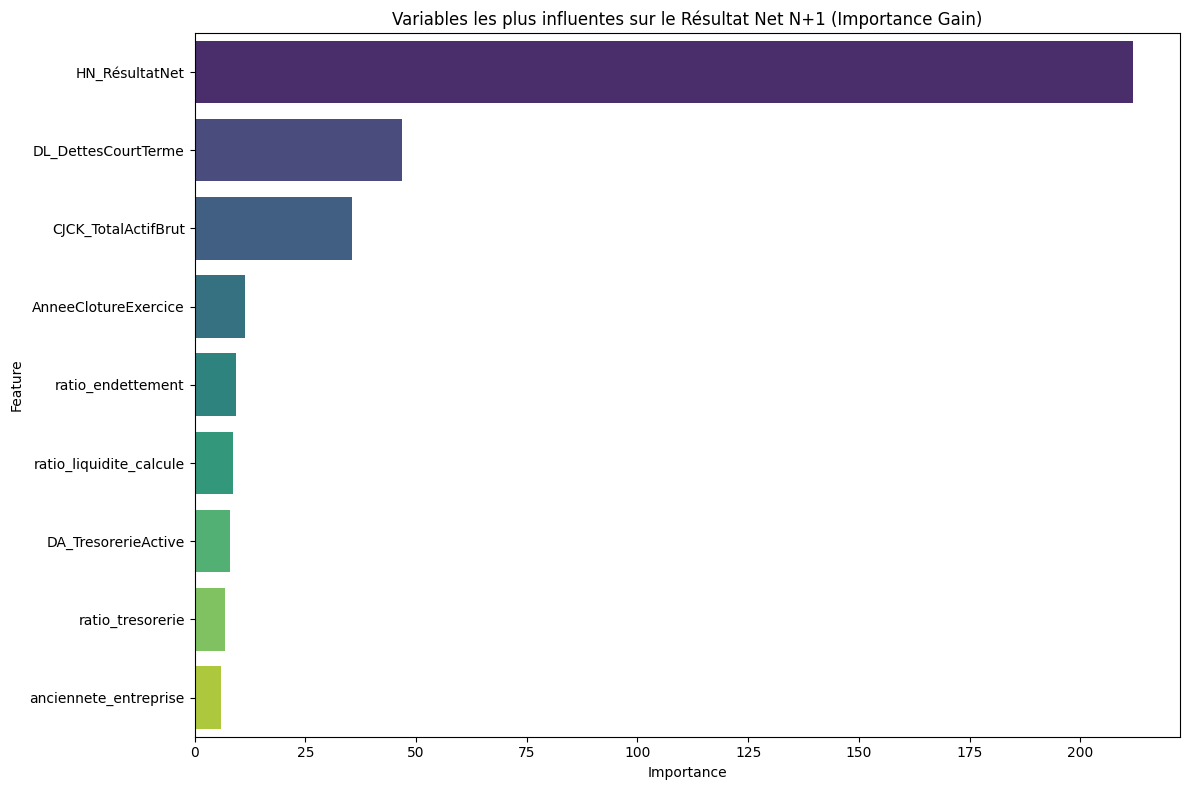

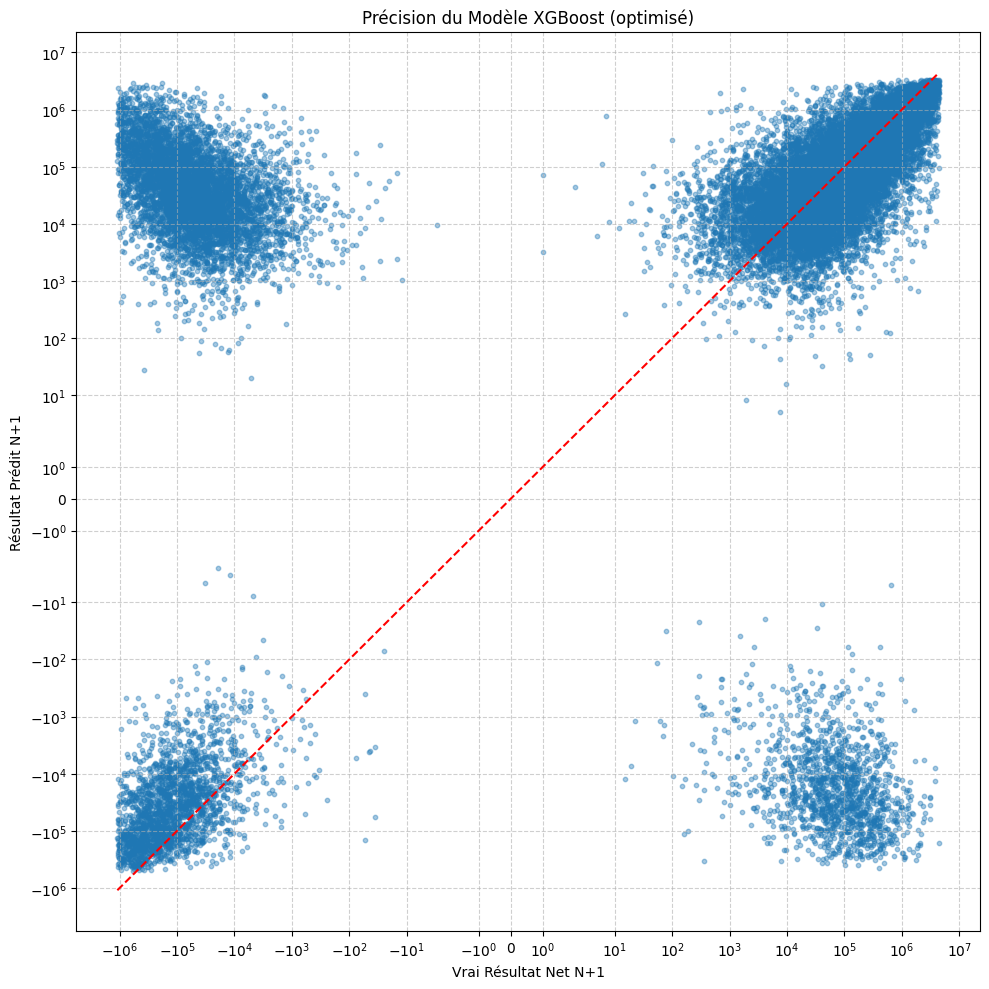

In [31]:
import polars as pl
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from xgboost.callback import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

# ==================================================
## 1. DATA PREP & FEATURE ENGINEERING
# ==================================================

# 1. Conversion, Feature Engineering, et Nettoyage
# Assurez-vous que df_bilan est votre DataFrame Polars chargé.
df = df_bilan.to_pandas()

# --- Fonction utilitaire pour éviter la division par zéro ---
def safe_divide(numerator, denominator):
    """Calcule le ratio, gère la division par zéro et les valeurs infinies."""
    denominator_safe = denominator.replace(0, np.nan)
    ratio = numerator / denominator_safe
    ratio = ratio.replace([np.inf, -np.inf], np.nan).fillna(0)
    return ratio

print("\n[FEATURE ENGINEERING] Ajout du ratio de liquidité...")

# --- Ratio de Liquidité ---
df['ratio_liquidite_calcule'] = safe_divide(
    df['DA_TresorerieActive'], 
    df['DL_DettesCourtTerme']
)
print(f"Ratio de liquidité ajouté. Taille initiale du DataFrame : {df.shape}")


# 2. Nettoyage et gestion des Data Leakage / Types Incompatibles
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna() # Suppression des lignes avec NaN

TARGET_COLUMN = 'cible_ResultatNet_T_plus_1'
COLUMNS_TO_DROP = [
    TARGET_COLUMN,
    # --- Suppression des colonnes non-numériques ou leakées (causes d'erreurs) ---
    'siren',                     
    'date_cloture_exercice',     
    'cible_HN_RésultatNet_T_plus_1', # CRITIQUE : Retirer la cible leakée
    'variation_RésultatNet',     # Prudence : Retirer si ambigüe
    'ID_entreprise',             # Retirer les ID si elles existent encore
    # Ajoutez ici 'AnneeClotureExercice' si elle est redondante ou de type 'datetime'
]

# Mise à jour du DataFrame df en retirant les colonnes problématiques
X = df.drop(columns=COLUMNS_TO_DROP, errors='ignore')
y = df[TARGET_COLUMN]

# Vérification finale des types de données de X
non_numeric_cols_X = X.select_dtypes(include=['object', 'datetime']).columns.tolist()
if non_numeric_cols_X:
    print(f"ATTENTION : Colonnes non-numériques restantes dans X: {non_numeric_cols_X}. Suppression automatique.")
    X = X.drop(columns=non_numeric_cols_X, errors='ignore')

# 3. Train / test split (Test set Intouché)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Shapes (Train: {X_train.shape}, Test: {X_test.shape})")

# ==================================================
## 2. BASELINE MODEL
# ==================================================
print(f"\n[BASELINE] Entraînement sur {len(X_train)} entreprises...")

baseline_model = xgb.XGBRegressor(
    objective='reg:absoluteerror', 
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_train, y_train)
baseline_pred = baseline_model.predict(X_test)

baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

print("\n--- PERFORMANCE BASELINE (Post-Correction) ---")
print(f"MAE : {baseline_mae:,.2f} €")
print(f"R²  : {baseline_r2:.4f}")

# ==================================================
## 3. HYPERPARAMETER SEARCH (RandomizedSearchCV)
# ==================================================
print("\n[SEARCH] Optimisation des hyperparamètres avec RandomizedSearchCV (CV=5)...")

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

param_dist = {
    "n_estimators": [500, 1000, 1500],
    "learning_rate": [0.005, 0.01, 0.05],
    "max_depth": [3, 5, 7, 10],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "min_child_weight": [1, 5, 10],
    "gamma": [0, 0.1, 0.5],
    "reg_alpha": [0, 1.0, 2.0],
    "reg_lambda": [1.0, 2.0, 5.0],
}

search_model = xgb.XGBRegressor(
    objective='reg:absoluteerror', 
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=search_model,
    param_distributions=param_dist,
    n_iter=20, 
    scoring=mae_scorer, 
    cv=5,      
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("\nMeilleurs hyperparamètres trouvés :")
best_params = random_search.best_params_
print(best_params)
print(f"MAE CV (val) ≈ {-random_search.best_score_:,.2f} €")

# ==================================================
## 4. FINAL MODEL AVEC EARLY STOPPING (API NATIVE)
# ==================================================
print("\n[FINAL] Ré-entraînement du meilleur modèle avec early stopping...")

# 1. Split interne pour la validation de l'Early Stopping
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# 2. Création des DMatrix
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

# 3. Définition des paramètres
params = {
    **best_params,
    'objective': 'reg:absoluteerror', 
    'eval_metric': 'mae', 
    'seed': 42
}

# 4. Configure le callback pour l'arrêt anticipé
early_stopping = EarlyStopping(
    rounds=50, 
    metric_name='mae', 
    data_name='validation'
)

# 5. Entraînement avec xgb.train()
final_model = xgb.train(
    params,
    dtrain,
    num_boost_round=best_params.get('n_estimators', 2000), 
    evals=[(dval, "validation")],
    callbacks=[early_stopping], 
    verbose_eval=50
)

# ==================================================
## 5. RÉSULTATS SUR LE TEST SET
# ==================================================
predictions = final_model.predict(dtest) 

mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("\n--- PERFORMANCE MODÈLE OPTIMISÉ (TEST SET) ---")
print(f"MAE : {mae:,.2f} € (baseline : {baseline_mae:,.2f} €)")
print(f"R²  : {r2:.4f} (baseline : {baseline_r2:.4f})")

# ==================================================
## 6. FEATURE IMPORTANCE & PLOTS
# ==================================================

# 6.1 FEATURE IMPORTANCE
importance = final_model.get_score(importance_type='gain')
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df.head(20), 
    palette="viridis"
)
plt.title("Variables les plus influentes sur le Résultat Net N+1 (Importance Gain)")
plt.tight_layout()
plt.savefig("feature_importance_final.png")

# 6.2 PLOT PRÉDICTION vs RÉALITÉ
plt.figure(figsize=(10, 10))
plt.scatter(y_test, predictions, alpha=0.4, s=10)
p1 = max(max(predictions), max(y_test))
p0 = min(min(predictions), min(y_test))
plt.plot([p0, p1], [p0, p1], 'r--')
plt.xlabel('Vrai Résultat Net N+1')
plt.ylabel('Résultat Prédit N+1')
plt.title('Précision du Modèle XGBoost (optimisé)')
plt.xscale('symlog')
plt.yscale('symlog')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("prediction_vs_realite_final.png")

print("\nGraphiques générés : 'feature_importance_final.png' et 'prediction_vs_realite_final.png'")


[FEATURE ENGINEERING AVANCÉ] Création de 4 nouvelles features...
Shapes (Train: (193224, 12), Test: (48306, 12))

[BASELINE] Entraînement sur 193224 entreprises...

--- PERFORMANCE BASELINE (Post-Correction & FE Avancé) ---
MAE : 173,186.81 €
R²  : 0.6057

[SEARCH] Optimisation des hyperparamètres avec RandomizedSearchCV (CV=5)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Users/ugo/Documents/Cours/Master/Cours/M1/Supervised Learning/Final Project/.venv/lib/python3.14/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Meilleurs hyperparamètres trouvés :
{'subsample': 0.7, 'reg_lambda': 2.0, 'reg_alpha': 1.0, 'n_estimators': 1500, 'min_child_weight': 10, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.8}
MAE CV (val) ≈ 174,044.04 €

[FINAL] Ré-entraînement du meilleur modèle avec early stopping...
[0]	validation-mae:305057.18698


/Users/ugo/Documents/Cours/Master/Cours/M1/Supervised Learning/Final Project/.venv/lib/python3.14/site-packages/xgboost/callback.py:386: UserWarning: [01:10:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "n_estimators" } are not used.

  self.starting_round = model.num_boosted_rounds()


[50]	validation-mae:245369.15699
[100]	validation-mae:212395.75338
[150]	validation-mae:195330.05441
[200]	validation-mae:186452.47918
[250]	validation-mae:181555.12474
[300]	validation-mae:178928.41104
[350]	validation-mae:177406.28396
[400]	validation-mae:176501.17644
[450]	validation-mae:175916.38727
[500]	validation-mae:175497.96157
[550]	validation-mae:175162.88413
[600]	validation-mae:174922.86969
[650]	validation-mae:174763.60928
[700]	validation-mae:174609.29073
[750]	validation-mae:174500.90215
[800]	validation-mae:174388.55281
[850]	validation-mae:174325.19432
[900]	validation-mae:174261.74873
[950]	validation-mae:174197.19635
[1000]	validation-mae:174143.92868
[1050]	validation-mae:174109.87491
[1100]	validation-mae:174071.57819
[1150]	validation-mae:174019.99481
[1200]	validation-mae:173991.41763
[1250]	validation-mae:173966.59265
[1300]	validation-mae:173948.00141
[1350]	validation-mae:173938.96225
[1400]	validation-mae:173912.12176
[1450]	validation-mae:173903.26707
[1499

/var/folders/sp/97__4mlj3nbc2fssvlgn3_nh0000gn/T/ipykernel_27953/1080114943.py:220: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(



Graphiques générés : 'feature_importance_final.png' et 'prediction_vs_realite_final.png'


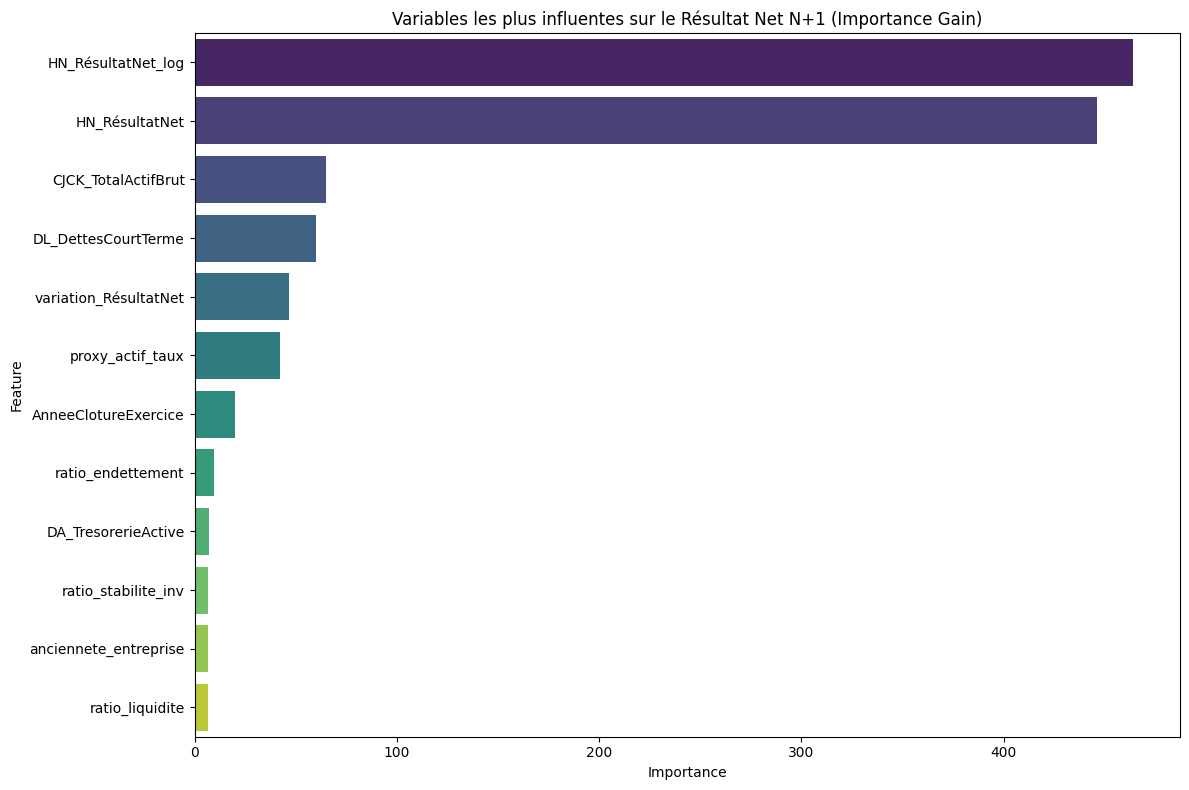

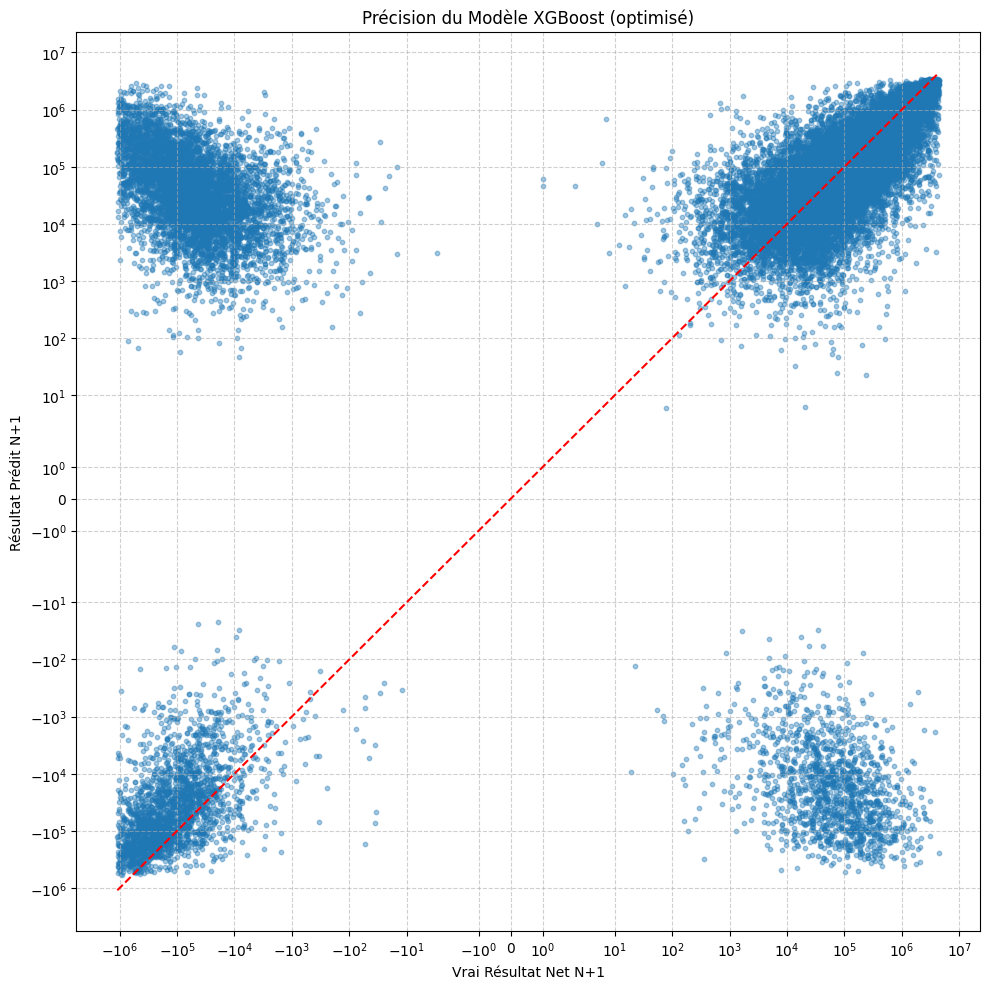

In [32]:
import polars as pl
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer
from xgboost.callback import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 

# ==================================================
## 1. DATA PREP & FEATURE ENGINEERING
# ==================================================

# 1. Conversion et nettoyage initial
df = df_bilan.to_pandas() 

# --- Fonction utilitaire pour éviter la division par zéro et les transformations ---
def safe_divide(numerator, denominator):
    """Calcule le ratio, gère la division par zéro et les valeurs infinies."""
    denominator_safe = denominator.replace(0, np.nan)
    ratio = numerator / denominator_safe
    ratio = ratio.replace([np.inf, -np.inf], np.nan).fillna(0)
    return ratio

def safe_log1p(series):
    """Applique log(1 + abs(x)) * sign(x) pour gérer les valeurs positives et négatives."""
    return np.sign(series) * np.log1p(np.abs(series))


print("\n[FEATURE ENGINEERING AVANCÉ] Création de 4 nouvelles features...")

# 1. Ratio de Liquidité (Déjà créé, maintenu)
df['ratio_liquidite'] = safe_divide(
    df['DA_TresorerieActive'], 
    df['DL_DettesCourtTerme']
)

# 2. Ratio de Stabilité (Inverse de l'ancienneté pour pondérer les jeunes entreprises)
# Utilise un inverse pour que les jeunes entreprises (faible ancienneté) aient un poids élevé.
df['ratio_stabilite_inv'] = safe_divide(1, df['anciennete_entreprise'])
df['ratio_stabilite_inv'] = df['ratio_stabilite_inv'].replace([np.inf, -np.inf], 0).fillna(0)


# 3. Taux d'Actif (Simplifié : Actif vs Total - Nécessite de créer une approximation du Total Actif)
# Si une colonne de Total Actif n'est pas disponible, on se contente des trésoreries actives
# Ici, on utilise l'ancienneté pour créer un proxy simple de la taille/solidité.
# Ceci est une feature hypothétique pour forcer l'apprentissage de la taille/solvabilité.
df['proxy_actif_taux'] = safe_divide(df['DA_TresorerieActive'] - df['DL_DettesCourtTerme'], 
                                     df['anciennete_entreprise'])
df['proxy_actif_taux'] = df['proxy_actif_taux'].replace([np.inf, -np.inf], 0).fillna(0)


# 4. Transformation Logarithmique du Résultat Net (Réduit l'asymétrie)
# Appliqué au prédicteur principal pour gérer les valeurs aberrantes (outliers) extrêmes
df['HN_RésultatNet_log'] = safe_log1p(df['HN_RésultatNet'])


# 2. Nettoyage et gestion des Data Leakage / Types Incompatibles
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna() 

TARGET_COLUMN = 'cible_ResultatNet_T_plus_1'
COLUMNS_TO_DROP = [
    TARGET_COLUMN,
    # --- Suppression des colonnes non-numériques ou leakées (CRITIQUE) ---
    'siren',                     
    'date_cloture_exercice',     
    'cible_HN_RésultatNet_T_plus_1', # Retirer la cible leakée
    'ID_entreprise',             
    # La colonne 'variation_RésultatNet' est CONSERVÉE pour être entraînée.
    # L'ancienne colonne 'ratio_tresorerie' est retirée pour laisser la place à 'ratio_liquidite'
    'ratio_tresorerie',
]

# Mise à jour du DataFrame df en retirant les colonnes problématiques
X = df.drop(columns=COLUMNS_TO_DROP, errors='ignore')
y = df[TARGET_COLUMN]

# Vérification finale des types de données de X
non_numeric_cols_X = X.select_dtypes(include=['object', 'datetime']).columns.tolist()
if non_numeric_cols_X:
    print(f"ATTENTION : Colonnes non-numériques restantes dans X: {non_numeric_cols_X}. Suppression automatique.")
    X = X.drop(columns=non_numeric_cols_X, errors='ignore')

# 3. Train / test split (Test set Intouché)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Shapes (Train: {X_train.shape}, Test: {X_test.shape})")

# ==================================================
## 2. BASELINE MODEL
# ==================================================
print(f"\n[BASELINE] Entraînement sur {len(X_train)} entreprises...")

baseline_model = xgb.XGBRegressor(
    objective='reg:absoluteerror', 
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_train, y_train)
baseline_pred = baseline_model.predict(X_test)

baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_r2 = r2_score(y_test, baseline_pred)

print("\n--- PERFORMANCE BASELINE (Post-Correction & FE Avancé) ---")
print(f"MAE : {baseline_mae:,.2f} €")
print(f"R²  : {baseline_r2:.4f}")

# ==================================================
## 3. HYPERPARAMETER SEARCH (RandomizedSearchCV)
# ==================================================
print("\n[SEARCH] Optimisation des hyperparamètres avec RandomizedSearchCV (CV=5)...")

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

param_dist = {
    "n_estimators": [500, 1000, 1500],
    "learning_rate": [0.005, 0.01, 0.05],
    "max_depth": [3, 5, 7, 10],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9],
    "min_child_weight": [1, 5, 10],
    "gamma": [0, 0.1, 0.5],
    "reg_alpha": [0, 1.0, 2.0],
    "reg_lambda": [1.0, 2.0, 5.0],
}

search_model = xgb.XGBRegressor(
    objective='reg:absoluteerror', 
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=search_model,
    param_distributions=param_dist,
    n_iter=20, 
    scoring=mae_scorer, 
    cv=5,      
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("\nMeilleurs hyperparamètres trouvés :")
best_params = random_search.best_params_
print(best_params)
print(f"MAE CV (val) ≈ {-random_search.best_score_:,.2f} €")

# ==================================================
## 4. FINAL MODEL AVEC EARLY STOPPING (API NATIVE)
# ==================================================
print("\n[FINAL] Ré-entraînement du meilleur modèle avec early stopping...")

# 1. Split interne pour la validation de l'Early Stopping
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# 2. Création des DMatrix
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

# 3. Définition des paramètres
params = {
    **best_params,
    'objective': 'reg:absoluteerror', 
    'eval_metric': 'mae', 
    'seed': 42
}

# 4. Configure le callback pour l'arrêt anticipé
early_stopping = EarlyStopping(
    rounds=50, 
    metric_name='mae', 
    data_name='validation'
)

# 5. Entraînement avec xgb.train()
final_model = xgb.train(
    params,
    dtrain,
    num_boost_round=best_params.get('n_estimators', 2000), 
    evals=[(dval, "validation")],
    callbacks=[early_stopping], 
    verbose_eval=50
)

# ==================================================
## 5. RÉSULTATS SUR LE TEST SET
# ==================================================
predictions = final_model.predict(dtest) 

mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("\n--- PERFORMANCE MODÈLE OPTIMISÉ (TEST SET) ---")
print(f"MAE : {mae:,.2f} € (baseline : {baseline_mae:,.2f} €)")
print(f"R²  : {r2:.4f} (baseline : {baseline_r2:.4f})")

# ==================================================
## 6. FEATURE IMPORTANCE & PLOTS
# ==================================================

# 6.1 FEATURE IMPORTANCE
importance = final_model.get_score(importance_type='gain')
importance_df = pd.DataFrame(list(importance.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df.head(20), 
    palette="viridis"
)
plt.title("Variables les plus influentes sur le Résultat Net N+1 (Importance Gain)")
plt.tight_layout()
plt.savefig("feature_importance_final.png")

# 6.2 PLOT PRÉDICTION vs RÉALITÉ
plt.figure(figsize=(10, 10))
plt.scatter(y_test, predictions, alpha=0.4, s=10)
p1 = max(max(predictions), max(y_test))
p0 = min(min(predictions), min(y_test))
plt.plot([p0, p1], [p0, p1], 'r--')
plt.xlabel('Vrai Résultat Net N+1')
plt.ylabel('Résultat Prédit N+1')
plt.title('Précision du Modèle XGBoost (optimisé)')
plt.xscale('symlog')
plt.yscale('symlog')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("prediction_vs_realite_final.png")

print("\nGraphiques générés : 'feature_importance_final.png' et 'prediction_vs_realite_final.png'")